In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20000)
pd.options.mode.chained_assignment = None #Ignore Error: SettingWithCopyWarning
import math
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import os
import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

keras.backend.clear_session()

# Load the data

In [2]:
#df = pd.read_csv('../data/preprocessed/cleaned_data_v8.csv', delimiter=",")
df = pd.read_csv('../data/preprocessed/cleaned_data_agg_v1.csv', delimiter=",")

key_list = df.keys().tolist()

for x in range(len(key_list)):
    if not df.columns[x] == "datum":
        if not df.columns[x] == "container_id":
            df = df.astype({key_list[x]: "float32"})

# Delete unwanted data; cast datetime

In [3]:
df = df.drop(columns=["height_in_cm"])

# set date as index ancd convert to float
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index(df['datum'])
df = df.sort_index()
df['datum_float'] = df['datum'].values.astype(float)

# Split into train/test

In [4]:
# create train test partition
training_set = df['2020-05-09 00:00:00':'2021-01-29 23:59:59']
test_set  = df['2021-01-30 00:00:00':]
container_number = 2
training_set = training_set[training_set['container_id']==container_number]
test_set = test_set[test_set['container_id']==container_number]
print('Train Dataset:',training_set.shape)
print('Test Dataset:',test_set.shape)

Train Dataset: (264, 25)
Test Dataset: (99, 25)


C:\Users\david\AppData\Local\Temp/ipykernel_8736/3379989450.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  training_set = df['2020-05-09 00:00:00':'2021-01-29 23:59:59']
C:\Users\david\AppData\Local\Temp/ipykernel_8736/3379989450.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_set  = df['2021-01-30 00:00:00':]


In [5]:
y_training_set = pd.DataFrame(training_set["hight_delta"].values.tolist(), columns=["hight_delta"])
training_set = training_set.drop(columns=["hight_delta", "datum"])
####
y_test_set = pd.DataFrame(test_set["hight_delta"].values.tolist(), columns=["hight_delta"])
test_set = test_set.drop(columns=["hight_delta", "datum"])

# Prepare the training data

In [6]:
#https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
#https://analyticsindiamag.com/hands-on-guide-to-lstm-recurrent-neural-network-for-stock-market-prediction/
# Feature Scaling

# ****************** START TUNING *************
timelag = 5 #10
epochs_number = 1000 #10
batch_size_number = 32 #32

# ****************** END TUNING *************

train_set = training_set.iloc[:,:].values
y_train_set = y_training_set.iloc[:,:].values

sc = MinMaxScaler(feature_range = (0, 1))
sc1 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
y_train_set_scaled = sc1.fit_transform(y_train_set)

X_train = []
y_train = []
for i in range(timelag, len(training_set)-1):
    X_train.append(training_set_scaled[i-timelag:i, :])
    y_train.append(y_train_set_scaled[i-1, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)

# Configure the model

In [7]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = X_train[0].shape))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

#first callback method
#reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,
#patience=25, min_lr=0.0000001, min_delta=0.0001)
#default value lr = 0.001
#callbacks = [reduce_lr]

# Second callback mehod
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model

Epoch 1/1000
9/9 [==============================] - 29s 22ms/step - loss: 0.6722
Epoch 2/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.3542
Epoch 3/1000
9/9 [==============================] - ETA: 0s - loss: 0.068 - 0s 16ms/step - loss: 0.0700
Epoch 4/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0637
Epoch 5/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0491
Epoch 6/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0537
Epoch 7/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0512
Epoch 8/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0517
Epoch 9/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0450
Epoch 10/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0465
Epoch 11/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0378
Epoch 12/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0483
Epoch 13/100

9/9 [==============================] - 0s 17ms/step - loss: 0.0445
Epoch 102/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0517
Epoch 103/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0452
Epoch 104/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0524
Epoch 105/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0417
Epoch 106/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0374
Epoch 107/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0468
Epoch 108/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0447
Epoch 109/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0498
Epoch 110/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0389
Epoch 111/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0408
Epoch 112/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0499
Epoch 113/1000
9/9 [===========

9/9 [==============================] - 0s 16ms/step - loss: 0.0369
Epoch 202/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0414
Epoch 203/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0503
Epoch 204/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0438
Epoch 205/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0443
Epoch 206/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0454
Epoch 207/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0409
Epoch 208/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0451
Epoch 209/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0434
Epoch 210/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0362
Epoch 211/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0458
Epoch 212/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0411
Epoch 213/1000
9/9 [===========

9/9 [==============================] - 0s 19ms/step - loss: 0.0358
Epoch 302/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0383
Epoch 303/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0348
Epoch 304/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0334
Epoch 305/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0348
Epoch 306/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0345
Epoch 307/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0338
Epoch 308/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0410
Epoch 309/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0317
Epoch 310/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0343
Epoch 311/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0307
Epoch 312/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0291
Epoch 313/1000
9/9 [===========

9/9 [==============================] - 0s 20ms/step - loss: 0.0273
Epoch 402/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0295
Epoch 403/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0252
Epoch 404/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0250
Epoch 405/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0322
Epoch 406/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0280
Epoch 407/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0312
Epoch 408/1000
9/9 [==============================] - 0s 21ms/step - loss: 0.0274
Epoch 409/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0299
Epoch 410/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0282
Epoch 411/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0244
Epoch 412/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 413/1000
9/9 [===========

9/9 [==============================] - 0s 16ms/step - loss: 0.0279
Epoch 501/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0237
Epoch 502/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0290
Epoch 503/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0223
Epoch 504/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0230
Epoch 505/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0207
Epoch 506/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0262
Epoch 507/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0293
Epoch 508/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0249
Epoch 509/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0301
Epoch 510/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0296
Epoch 511/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0246
Epoch 512/1000
9/9 [===========

9/9 [==============================] - 0s 16ms/step - loss: 0.0215
Epoch 600/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0217
Epoch 601/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0262
Epoch 602/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0229
Epoch 603/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0235
Epoch 604/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0197
Epoch 605/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0182
Epoch 606/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0241
Epoch 607/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0182
Epoch 608/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0202
Epoch 609/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0202
Epoch 610/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0229
Epoch 611/1000
9/9 [===========

9/9 [==============================] - 0s 16ms/step - loss: 0.0129
Epoch 700/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0110
Epoch 701/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0100
Epoch 702/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0115
Epoch 703/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 704/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0112
Epoch 705/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0095
Epoch 706/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 707/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0120
Epoch 708/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0099
Epoch 709/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0102
Epoch 710/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0092
Epoch 711/1000
9/9 [===========

9/9 [==============================] - 0s 17ms/step - loss: 0.0133
Epoch 800/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0142
Epoch 801/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0100
Epoch 802/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0110
Epoch 803/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0104
Epoch 804/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0087
Epoch 805/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0086
Epoch 806/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0088
Epoch 807/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0099
Epoch 808/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0075
Epoch 809/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0088
Epoch 810/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0100
Epoch 811/1000
9/9 [===========

9/9 [==============================] - 0s 17ms/step - loss: 0.0179
Epoch 900/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0169
Epoch 901/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0181
Epoch 902/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0147
Epoch 903/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0170
Epoch 904/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0152
Epoch 905/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0166
Epoch 906/1000
9/9 [==============================] - 0s 19ms/step - loss: 0.0173
Epoch 907/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 908/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0130
Epoch 909/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0150
Epoch 910/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0163
Epoch 911/1000
9/9 [===========

9/9 [==============================] - 0s 20ms/step - loss: 0.0075
Epoch 999/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0065
Epoch 1000/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0084


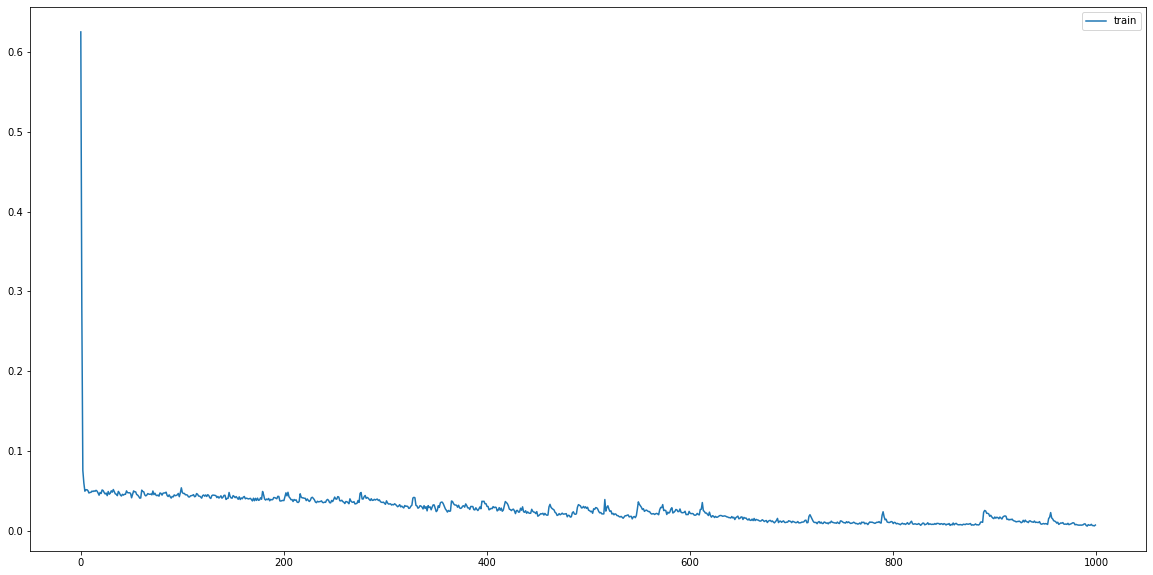

In [8]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = epochs_number, batch_size = batch_size_number)
#, callbacks = callbacks
# callbacks=[es_callback]
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Prepare the test data

In [9]:
test_set = test_set.iloc[:,:].values
y_test_set = y_test_set.iloc[:,:].values

sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_set)

Y_test = []
X_test = []
for i in range(timelag, len(test_set)-1):
    X_test.append(test_set_scaled[i-timelag:i, :])
    Y_test.append(y_test_set[i-1,0])
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [10]:
X_test.shape

(93, 5, 23)

# Predict

In [11]:
predicted_height = regressor.predict(X_test)
predicted_height = sc1.inverse_transform(predicted_height)

# Plot the prediction

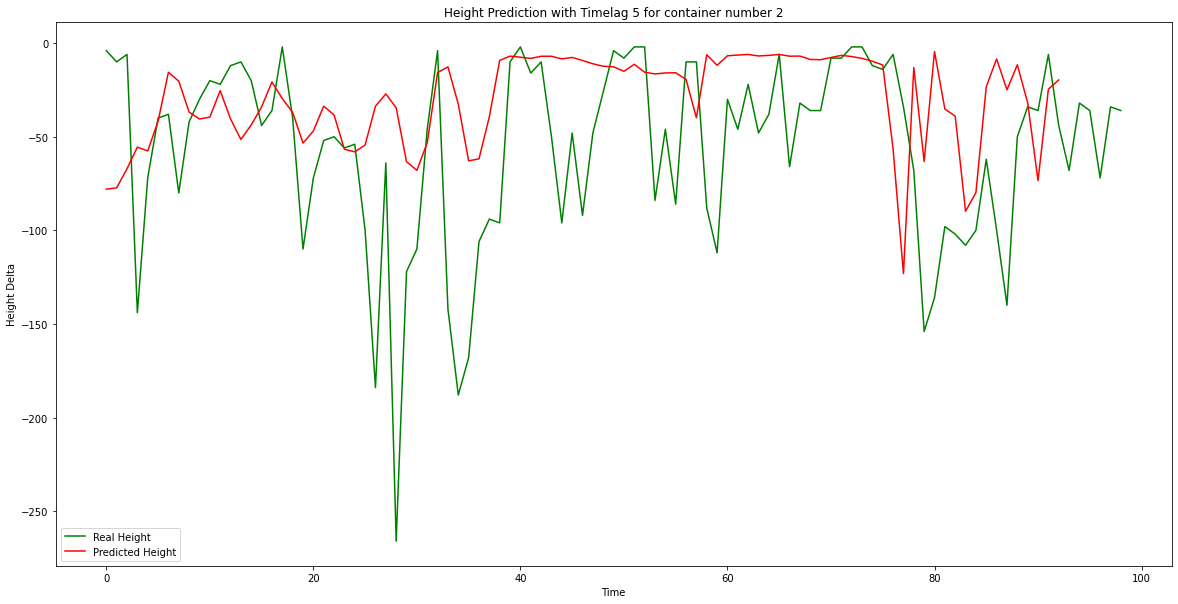

In [12]:
plt.figure(figsize=(20,10))
plt.plot(y_test_set, color = 'green', label = 'Real Height')
plt.plot(predicted_height, color = 'red', label = 'Predicted Height')
plt.title('Height Prediction with Timelag '+ str(timelag) + ' for container number ' +str(container_number))
plt.xlabel('Time')
plt.ylabel('Height Delta')
plt.legend()
plt.show()

# Export Model

In [14]:
regressor.save('../data/modeling/dev/test_model')

INFO:tensorflow:Assets written to: ../data/modeling/dev/test_model\assets


INFO:tensorflow:Assets written to: ../data/modeling/dev/test_model\assets
